# Feed-forward Artificial Neural Networks

In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import time

## Learning the XOR function

Let us consider the XOR ("exclusive or") function. The [truth table](https://en.wikipedia.org/wiki/Exclusive_or#Truth_table) of the XOR function is:

In [49]:
inputs = jnp.array([[0, 0], 
                   [0, 1], 
                   [1, 0], 
                   [1, 1]])
outputs = jnp.array([[0], 
                    [1], 
                    [1], 
                    [0]])

In [3]:
outputs.shape

(4, 1)

We consider a fully connected ANN with the following architechture and with $\tanh(\cdot)$ as activation function:

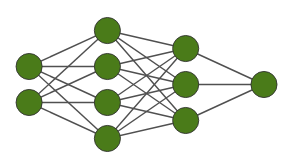

the input has 2 features and the output one value. Please note that we want 0 or 1 in out but we have a continuos function.. so we have to use an activation function to map the out in 0 or 1


The input of the network are the truth values of the two inputs (0 = False, 1 = True). The output is the **likelihood** (the "probability") of the truth value of the result. Hence, we want the output to be in $[0, 1]$. For this reason, we apply the activation function also to the last layer, and we rescale the output between 0 and 1.


The architecture is defined by the following **hyperparameters**:

In [5]:
n1, n2, n3, n4 = 2, 4, 3, 1

Define the parameters (weights and biases) of the ANN. 
Initialize the weights sampling from a standard normal distribution, and initialize to zero the biases.

Define both the weights and the biases as a 2-dimensional `numpy` array.

In [63]:
np.random.seed(0) # for reproducibility

def initialize_params():
  W1 = np.random.randn(n2,n1)
  b1 = np.zeros((n2,1))

  W2 = np.random.randn(n3,n2)
  b2 = np.zeros((n3,1))

  W3 = np.random.randn(n4,n3)
  b3 = np.zeros((n4,1))
  return [W1, b1, W2, b2, W3, b3]
params = initialize_params

Define a function that implements the ANN:
```python
def ANN(x, params):
  ...
```
with inputs:
- `x`: num_samples by 2 `numpy` array
- `params`: list of the parameters
and with output
- `y`: num_samples by 1 `numpy` array

Then, test the function on `inputs` and `params`.

In [35]:
def ANN(x, params):
  W1, b1, W2, b2, W3, b3 = params #we "extract" the params
  #return W3 @ (W2 @ (W1 @ x.transpose() - b1).transpose() - b2) - b3
  layer1 = x.T
  layer2 =  jnp.tanh(jnp.dot(W1, layer1) - b1)
  layer3 =  jnp.tanh(jnp.dot(W2, layer2) - b2)
  layer4 =  jnp.tanh(jnp.dot(W3, layer3) - b3)
  layer4 = (1.+ layer4) / 2
  return layer4.T
ANN(inputs, params)

DeviceArray([[0.5       ],
             [0.57224154],
             [0.107804  ],
             [0.10987768]], dtype=float32)

Print the truth table associated with the ANN.

In [36]:
np.array([[1,0]]).shape, np.array([1,0]).shape

((1, 2), (2,))

In [37]:
for a in (0,1):
  for b in (0,1):
    #out = 1 if a!=b else 0
    out = ANN(np.array([[a,b]]),params)
    
    print('%d XOR %d --> %f' % (a, b, out))

0 XOR 0 --> 0.500000
0 XOR 1 --> 0.572242
1 XOR 0 --> 0.107804
1 XOR 1 --> 0.109878


Define a function that computes the quadratic loss on a set of data:
```python
def loss_quadratic(x, y, params):
  ...
```
with inputs:
- `x`: num_samples by 2 `numpy` array
- `y`: num_samples by 1 `numpy` array
- `params`: list of the parameters
and with output
- `loss`: scalar

Then, test the function on `inputs`, `outputs` and `params`.

In [51]:
def loss_quadratic(x, y, params):
  y_pred = ANN(x,params)
  return jnp.sum(jnp.square(y-y_pred))
float(loss_quadratic(inputs, outputs, params))

1.241064190864563

Define a function that computes the cross-entropy loss on a set of data:
```python
def loss_crossentropy(x, y, params):
  ...
```
with inputs:
- `x`: num_samples by 2 `numpy` array
- `y`: num_samples by 1 `numpy` array
- `params`: list of the parameters
and with output
- `loss`: scalar

Then, test the function on `inputs`, `outputs` and `params`.

In [52]:
def loss_xEnt(x, y, params):
  y_pred = ANN(x,params)
  error = (y * jnp.log(y_pred)+ (1-y) * jnp.log(1-y_pred))
  return -jnp.sum(error)

loss_xEnt(inputs, outputs, params)

DeviceArray(3.5951784, dtype=float32)

Using the JIT module of JAX, compile both the losses defined above and their gradients w.r.t. the parameters.

In [54]:
grad_quadr = jax.grad(loss_quadratic, argnums=2)
grad_Xent = jax.grad(loss_xEnt, argnums=2)
#to use jax i have to use all the function as jnp

In [55]:
grad_quad_jit = jax.jit(grad_quadr)
grad_Xent_jit = jax.jit(grad_Xent)
loss_quad_jit = jax.jit(loss_quadratic)
loss_Xent_jit = jax.jit(loss_xEnt)

In [46]:
%timeit loss_quadratic(inputs, outputs, params)

The slowest run took 13.46 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 188 µs per loop


In [59]:
%timeit loss_quad_jit(inputs, outputs, params)

The slowest run took 4580.62 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 16.3 µs per loop


In [57]:
%timeit loss_xEnt(inputs, outputs, params)


The slowest run took 8.32 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 273 µs per loop


In [58]:
%timeit loss_Xent_jit(inputs, outputs, params)

The slowest run took 13.94 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 16.1 µs per loop


Implement the GD (gradient descent) method, with learning rate 0.1 and train the ANN, using either the quadratic or the cross-entropy loss function.
Collect the training history of both loss functions at each training epoch and plot them. 

Finally, print the truth table associated with the ANN and compute its accuracy.

duration: 0.100462 s
Quad loss: 6.04e-04
Xent loss: 4.72e-02


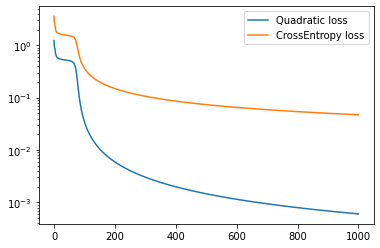

In [67]:
learning_rate = 0.1
max_iterations = 1000

np.random.seed(0)
params = initialize_params()

history_quad = [loss_quad_jit(inputs, outputs, params)]
history_xEnt = [loss_Xent_jit(inputs, outputs, params)]

t0 = time.time()
for epoch in range(max_iterations):
  grads = grad_quad_jit(inputs, outputs, params) # we loop over grads
  for i in range(len(params)):
    params[i] -= learning_rate * grads[i]
  history_quad.append(loss_quad_jit(inputs,outputs,params))
  history_xEnt.append(loss_Xent_jit(inputs,outputs,params))
duration = time.time() - t0

print('duration: %f s' % duration)
print('Quad loss: %1.2e' % history_quad[-1])
print('Xent loss: %1.2e' % history_xEnt[-1])

plt.semilogy(history_quad, label = 'Quadratic loss')
plt.semilogy(history_xEnt, label = 'CrossEntropy loss')
plt.legend()

train guided by the crossentropy loss

duration: 0.329017 s
Quad loss: 1.12e-06
Xent loss: 1.88e-03


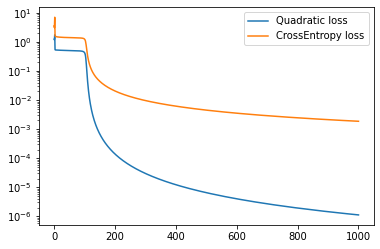

In [68]:
learning_rate = 0.1
max_iterations = 1000

np.random.seed(0)
params = initialize_params()

history_quad = [loss_quad_jit(inputs, outputs, params)]
history_xEnt = [loss_Xent_jit(inputs, outputs, params)]

t0 = time.time()
for epoch in range(max_iterations):
  grads = grad_Xent_jit(inputs, outputs, params) # we loop over grads
  for i in range(len(params)):
    params[i] -= learning_rate * grads[i]
  history_quad.append(loss_quad_jit(inputs,outputs,params))
  history_xEnt.append(loss_Xent_jit(inputs,outputs,params))
duration = time.time() - t0

print('duration: %f s' % duration)
print('Quad loss: %1.2e' % history_quad[-1])
print('Xent loss: %1.2e' % history_xEnt[-1])

plt.semilogy(history_quad, label = 'Quadratic loss')
plt.semilogy(history_xEnt, label = 'CrossEntropy loss')
plt.legend()

**Truth table after training:** no we have better values than in the initial case...

In [69]:
for a in (0,1):
  for b in (0,1):
    #out = 1 if a!=b else 0
    out = ANN(np.array([[a,b]]),params)
    
    print('%d XOR %d --> %f' % (a, b, out))

0 XOR 0 --> 0.000174
0 XOR 1 --> 0.999637
1 XOR 0 --> 0.999160
1 XOR 1 --> 0.000499


In [73]:
TP = ANN(np.array([[1,0],
                   [1,0]]), params)
TN = 1 - ANN(np.array([[0,0],
                   [1,1]]), params)
accuracy= (sum(TP) + sum(TN)) / 4
print(accuracy)

[0.99941146]
